# Predicción del valor de Bitcoin

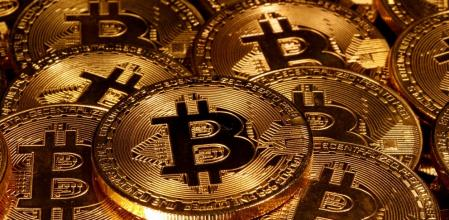

A partir del dataset `data/Binance_BTCUSDT_d.csv` implementa un modelo de series temporales para predecir el precio diario de cierre del Bitcoin en dólares

In [106]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [107]:
data = pd.read_csv('../../26_12_2023/ejercicios/data/Binance_BTCUSDT_d.csv',header=1,parse_dates=['date'])
data = data.sort_values('date')
print(data.shape)
data.head()

(1434, 10)


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
1433,1.502928e+09,2017-08-17,BTC/USDT,4469.93,4485.39,4200.74,4285.08,647.86,2812379.11,NaN
1432,1.503014e+09,2017-08-18,BTC/USDT,4285.08,4371.52,3938.77,4108.37,1178.07,4994493.56,NaN
1431,1.503101e+09,2017-08-19,BTC/USDT,4108.37,4184.69,3850.00,4139.98,371.15,1508239.39,NaN
1430,1.503187e+09,2017-08-20,BTC/USDT,4139.98,4211.08,4032.62,4086.29,463.54,1915636.35,NaN
1429,1.503274e+09,2017-08-21,BTC/USDT,4086.29,4119.62,3911.79,4016.00,685.12,2770592.06,NaN


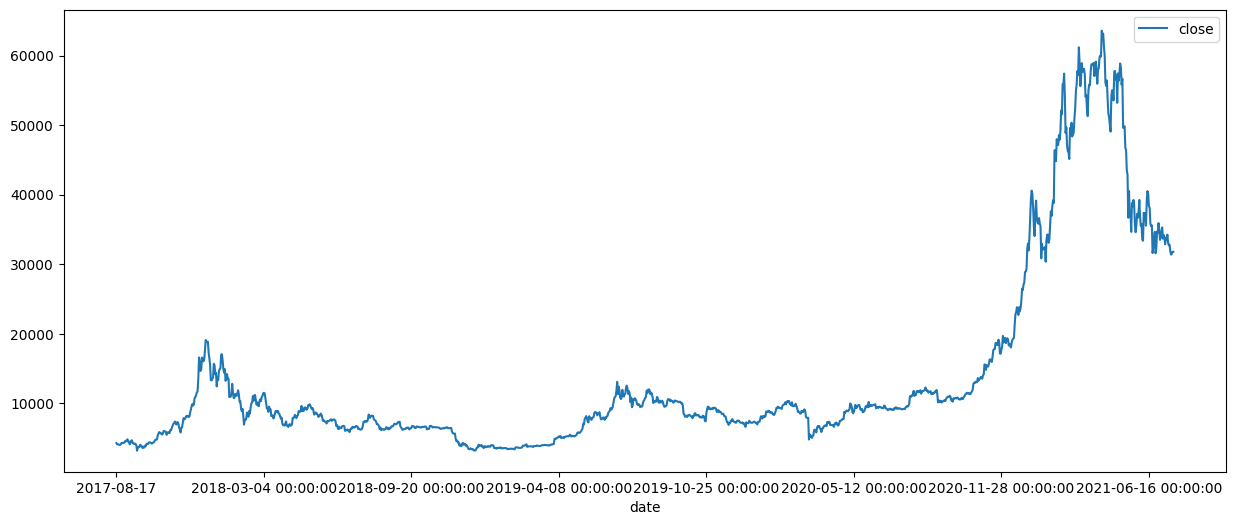

In [108]:
data[['date','close']].plot(x='date',y='close',figsize=(15,6))
plt.show()

## 1. Evalua la serie (autocorrelación, si es estacionaria o no, etc)

In [109]:
data.dtypes

unix           float64
date            object
symbol          object
open           float64
high           float64
low            float64
close          float64
Volume BTC     float64
Volume USDT    float64
tradecount     float64
dtype: object

In [110]:
data.drop(columns=['unix', 'symbol', 'tradecount', 'Volume BTC'], axis=1, inplace=True)
data.rename(columns={'Volume USDT':'volume'}, inplace=True)

In [111]:
data['date'] = data['date'].apply(lambda x: x.split(' ')[0])
data['date'] = pd.to_datetime(data['date'])

In [112]:
data = data.set_index('date')
data = data[~data.index.duplicated(keep='first')]
data = data.asfreq('D')

In [113]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['close'])
result[1]

0.7912082814584134

In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Multiplicative decomposition
result_mul = seasonal_decompose(data['close'], model='multiplicative', extrapolate_trend='freq')
# Additive decomposition
result_add = seasonal_decompose(data['close'], model='additive', extrapolate_trend='freq')

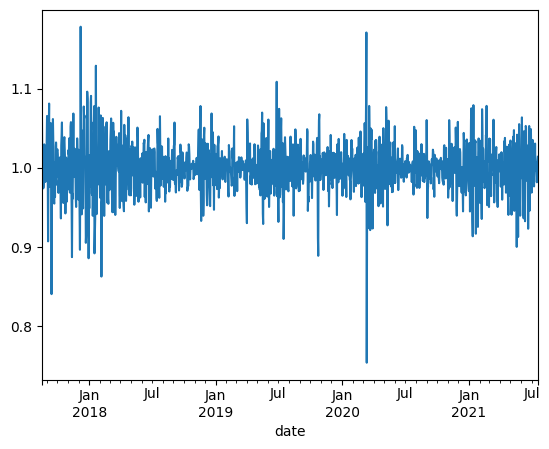

In [115]:
data['seasonal'] = result_mul.seasonal
data['trend'] = result_mul.trend
data['closeasonal'] = data['close'] / data['seasonal']
data['closeasonalwtrend'] = data['closeasonal'] / data['trend']
data['closeasonalwtrend'].plot()
plt.show()

In [116]:
adfuller(data['closeasonalwtrend'])[1]

1.257439435238915e-22

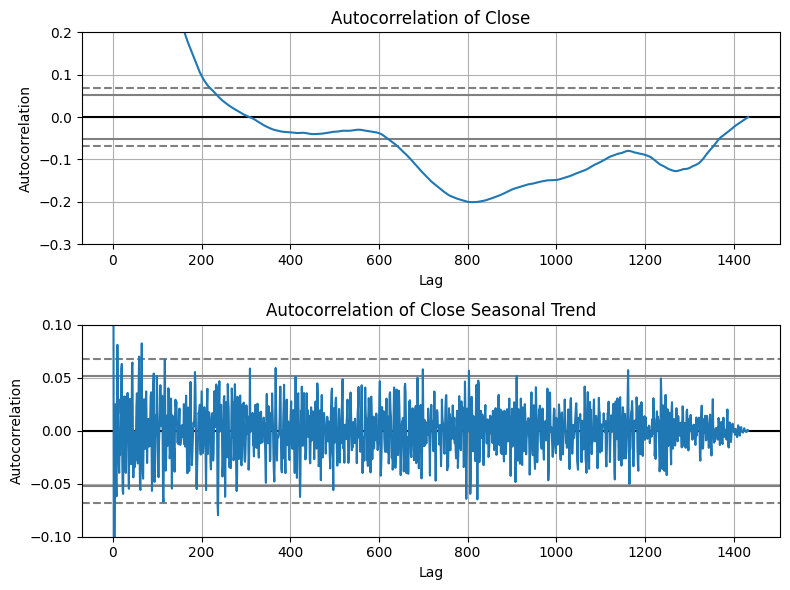

In [117]:
from pandas.plotting import autocorrelation_plot

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
autocorrelation_plot(data['close'], ax=axes[0])
axes[0].set_ylim(-0.3, 0.2)
axes[0].set_title('Autocorrelation of Close')
autocorrelation_plot(data['closeasonalwtrend'], ax=axes[1])
axes[1].set_ylim(-0.1, 0.1)
axes[1].set_title('Autocorrelation of Close Seasonal Trend')
plt.tight_layout()
plt.show()

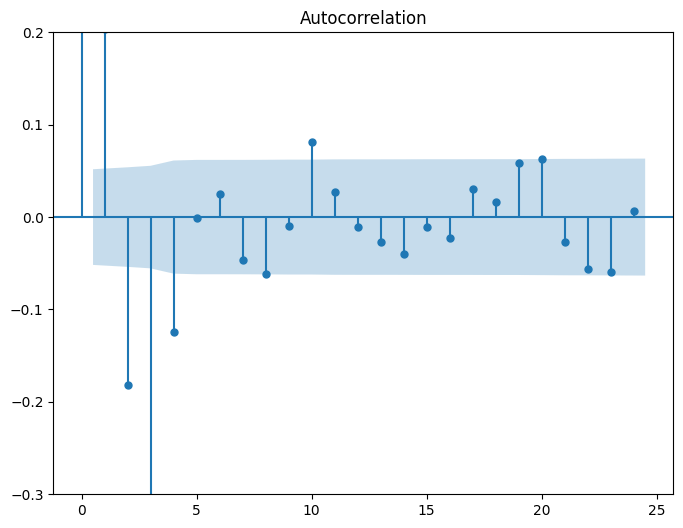

In [118]:
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plot_acf(data['closeasonalwtrend'],lags=24, ax=axes)
axes.set_ylim(-0.3, 0.2)
plt.show()

## 2. Divide el conjunto de datos en train-test

In [119]:
# Calcula el índice que representa el 80% de los datos
percent_80 = int(len(data) * 0.8)
# Selecciona el 80% de los datos
X_train = data['closeasonalwtrend'].iloc[:percent_80].values
# Selecciona el restante 20% de los datos
X_test = data['closeasonalwtrend'].iloc[percent_80:].values

## 3. Construye y prueba diferentes modelos para predecir la serie temporal

In [120]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
def lags_model_opt(X_train):
    p = range(0, 5)
    d = range(0, 5)
    q = range(0, 5)
    pdq = list(itertools.product(p, d, q))
    results = []
    for param in pdq:
        model_arima = ARIMA(X_train, order=param)
        model_arima_fit = model_arima.fit()
        results.append((param, model_arima_fit.aic))
    lags, mse = zip(*results)
    return lags[mse.index(min(mse))]

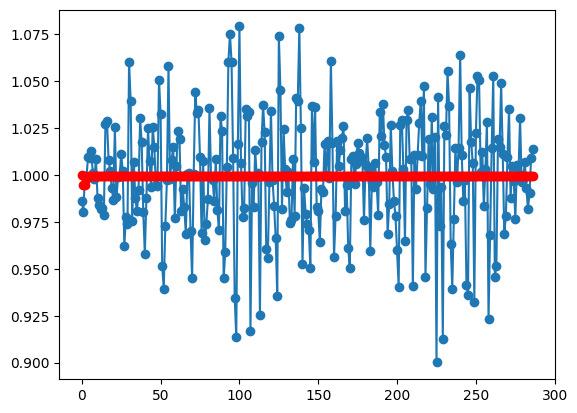

mean_squared_error: 0.0009661880760383402


In [121]:
lags = lags_model_opt(X_train)
model_ar = ARIMA(X_train, order=lags)
model_ar_fit = model_ar.fit()
predictions = model_ar_fit.predict(start=len(X_train), end=len(data) - 1)
plt.plot(X_test, 'o-')
plt.plot(predictions,'o-', color='red')
plt.show()
print("mean_squared_error:", mean_squared_error(X_test, predictions))